**Conclusion**

**TF_IDF with adding addtion weights to some keywords and implementing RandomForestRegression as Ensemble and neural networks produced good result then other methods.A spearman coefficient of 0.447 is for short term score using random forest and a long-term score of 0.243 using neural networks.
Random forest is used to generate short-term score, while neural networks is used to generate long-term score for test data.
Short Term and Long Term Memorability Score generated from this method are stored in Predicted_score.csv file. Result are transfered from this to original Dataset**




***Showing step by step how the above result was achieved***








**Mounting Google Drive to colab**

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
%pwd

'/gdrive'

**Importing the required libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
import numpy
from keras import regularizers
from keras import layers

Using TensorFlow backend.


In [0]:
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

**Reading HMP Features and the video names from the folder and**
**fetching the HMP features**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/HMP')

In [0]:
HMP_feature = []
video_name = []
for py in glob.glob('*.txt'):
    channel_values = open(py).read().split(" ")
    channel_values = np.array(channel_values)
    fp = []
    for i in range(len(channel_values)):
        file = channel_values[i].split(':')
        fp.append(file[1])
    HMP_feature.append(fp)
    py1 = py.split('.')
    video_name.append(py1[0])

**Transforming features into DataFrame**


In [0]:
HMP_features = pd.DataFrame(HMP_feature)
HMP_features['Video_name'] = video_name

In [0]:
HMP_features.fillna(value=pd.np.nan, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [0]:
HMP_features.fillna(0, inplace=True)

In [0]:
HMP_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,Video_name
0,0.012099,0.001466,0.000017,0.000683,0.000007,0.000007,0.000170,0.000002,0.000002,0.000002,0.003135,0.000045,0.000026,0.000005,0.000005,0.000005,0.000005,0.000031,0.011674,0.000537,0.000017,0.000442,0.000286,0.000014,0.000007,0.000014,0.000002,0.000078,0.000123,0.000009,0.000002,0.000005,0.000005,0.000253,0.001033,0.000045,0.000007,0.000045,0.000019,0.000007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,video6634
1,0.078170,0.013597,0.000122,0.005590,0.000074,0.000026,0.001137,0.000017,0.000017,0.023600,0.000126,0.000043,0.000009,0.000039,0.016778,0.001267,0.000069,0.000542,0.000638,0.000056,0.000009,0.000039,0.000013,0.000178,0.000395,0.000017,0.000004,0.000030,0.000004,0.000004,0.000004,0.000430,0.003242,0.000234,0.000022,0.000161,0.000082,0.000004,0.000004,0.000039,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,video6633
2,0.112506,0.014053,0.000263,0.043205,0.000560,0.000005,0.000364,0.002472,0.000206,0.000002,0.000064,0.021283,0.000939,0.000037,0.000710,0.000007,0.000007,0.000010,0.000113,0.000002,0.000010,0.000010,0.000246,0.002116,0.001187,0.000106,0.000474,0.001027,0.000157,0.000015,0.000076,0.000061,0.000167,0.000445,0.000069,0.000012,0.000071,0.000042,0.000007,0.000012,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,video6639
3,0.066072,0.012682,0.000283,0.006425,0.000375,0.000002,0.000174,0.002373,0.000152,0.000002,0.000102,0.000020,0.030889,0.002475,0.000071,0.001682,0.000015,0.000024,0.000594,0.000033,0.000018,0.000009,0.000082,0.000031,0.000166,0.004955,0.005047,0.002610,0.000126,0.000530,0.001755,0.000163,0.000013,0.000095,0.000068,0.000223,0.000742,0.000071,0.000015,0.000035,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,video6635
4,0.030360,0.005834,0.000169,0.006578,0.000542,0.000016,0.000373,0.001041,0.000113,0.000007,0.000102,0.000009,0.009697,0.000538,0.000061,0.000759,0.000005,0.000002,0.000009,0.000093,0.000002,0.000007,0.000032,0.000005,0.000018,0.000199,0.002286,0.000969,0.000068,0.000246,0.001100,0.000163,0.000023,0.000102,0.000104,0.000081,0.000305,0.000045,0.000014,0.000072,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,video6637


In [0]:
HMP_features.rename(columns={'Video_name':'video'},inplace=True)

**Reading ground_truth csv from Dev-Test**


In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Ground-truth')

In [0]:
ground_truth = pd.read_csv('ground-truth.csv')

**Removong annotations columns as they do not contribute in predicting memorability score**

In [0]:
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

**Removong ".txt" from videos name to merge with HMP Features**

In [0]:
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])

In [0]:
ground_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Combining HMP features and ground truth values into single dataframe using Video name**

In [0]:
fp = pd.merge(ground_truth, HMP_features , on='video')

In [0]:
fp.head(5)

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,4311,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350
0,video3,0.924,0.846,0.125563,0.024036,0.000314,0.015864,0.000358,0.000086,0.002795,0.000054,0.000037,0.000005,0.035348,0.000494,0.000010,0.000304,0.000025,0.000064,0.002866,0.001590,0.000094,0.000232,0.001857,0.000210,0.000005,0.000072,0.000153,0.000141,0.000560,0.000040,0.000017,0.000086,0.000052,0.000002,0.000007,0.000010,0.000420,0.004557,0.000333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,video4,0.923,0.667,0.007526,0.001421,0.000068,0.001184,0.000143,0.000079,0.000246,0.000024,0.000042,0.000004,0.003119,0.000490,0.000024,0.000455,0.000002,0.000004,0.000160,0.000002,0.000013,0.000004,0.000013,0.000617,0.002730,0.000637,0.000037,0.000259,0.000437,0.000090,0.000009,0.000022,0.000033,0.000079,0.000165,0.000007,0.000004,0.000011,0.000024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,video6,0.863,0.700,0.109584,0.018978,0.000289,0.008774,0.000208,0.000002,0.000088,0.002046,0.000061,0.000038,0.000002,0.039843,0.001253,0.000026,0.000698,0.000012,0.000007,0.000130,0.000002,0.000045,0.000002,0.000035,0.001258,0.004105,0.001946,0.000078,0.000430,0.001064,0.000073,0.000026,0.000043,0.000033,0.000194,0.000452,0.000019,0.000014,0.000035,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,video8,0.922,0.818,0.120431,0.013561,0.000277,0.018974,0.000913,0.000024,0.000713,0.002496,0.000149,0.000011,0.000157,0.000005,0.062173,0.001059,0.000040,0.001530,0.000013,0.000003,0.000160,0.000024,0.000003,0.000011,0.000458,0.002672,0.000947,0.000109,0.000282,0.001530,0.000242,0.000008,0.000106,0.000202,0.000096,0.000354,0.000037,0.000005,0.000064,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,video10,0.950,0.900,0.005026,0.001356,0.000055,0.000665,0.000029,0.000024,0.000147,0.000020,0.000724,0.000039,0.000024,0.000002,0.000002,0.000002,0.000011,0.001303,0.000689,0.000064,0.000136,0.000513,0.000086,0.000004,0.000022,0.000011,0.000042,0.000261,0.000026,0.000009,0.000053,0.000020,0.000020,0.000004,0.000088,0.000913,0.000090,0.000118,0.000066,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
fp.shape

(6000, 4354)

**Designing Model**

**Code for Calculating Spearmann's Correlation Coefficient**

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Splitting features to X and Y variable**

In [0]:
X = fp.iloc[:,3:6078].values
Y = fp.iloc[:, 1:3].values

In [0]:
Y

array([[0.924, 0.846],
       [0.923, 0.667],
       [0.863, 0.7  ],
       ...,
       [0.713, 0.818],
       [0.954, 1.   ],
       [0.953, 0.615]])

**Splitting dataset into Train and Test sets**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

**a) Implementing Linear Regression Model**

In [0]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Y_pred1 = regressor1.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.020
The Spearman's correlation coefficient is: -0.006


**b) Using KNN Regressor**

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [0]:
regressor4 = KNeighborsRegressor(n_neighbors=77)
regressor4.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=77, p=2,
                    weights='uniform')

In [0]:
Y_pred4 = regressor4.predict(X_test)
Get_score(Y_pred4, Y_test)

The Spearman's correlation coefficient is: 0.075
The Spearman's correlation coefficient is: 0.036


**c) Using SVR**


*calculating short-term memorability score*

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,4311,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350
0,video3,0.924,0.846,0.125563,0.024036,0.000314,0.015864,0.000358,0.000086,0.002795,0.000054,0.000037,0.000005,0.035348,0.000494,0.000010,0.000304,0.000025,0.000064,0.002866,0.001590,0.000094,0.000232,0.001857,0.000210,0.000005,0.000072,0.000153,0.000141,0.000560,0.000040,0.000017,0.000086,0.000052,0.000002,0.000007,0.000010,0.000420,0.004557,0.000333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,video4,0.923,0.667,0.007526,0.001421,0.000068,0.001184,0.000143,0.000079,0.000246,0.000024,0.000042,0.000004,0.003119,0.000490,0.000024,0.000455,0.000002,0.000004,0.000160,0.000002,0.000013,0.000004,0.000013,0.000617,0.002730,0.000637,0.000037,0.000259,0.000437,0.000090,0.000009,0.000022,0.000033,0.000079,0.000165,0.000007,0.000004,0.000011,0.000024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,video6,0.863,0.700,0.109584,0.018978,0.000289,0.008774,0.000208,0.000002,0.000088,0.002046,0.000061,0.000038,0.000002,0.039843,0.001253,0.000026,0.000698,0.000012,0.000007,0.000130,0.000002,0.000045,0.000002,0.000035,0.001258,0.004105,0.001946,0.000078,0.000430,0.001064,0.000073,0.000026,0.000043,0.000033,0.000194,0.000452,0.000019,0.000014,0.000035,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,video8,0.922,0.818,0.120431,0.013561,0.000277,0.018974,0.000913,0.000024,0.000713,0.002496,0.000149,0.000011,0.000157,0.000005,0.062173,0.001059,0.000040,0.001530,0.000013,0.000003,0.000160,0.000024,0.000003,0.000011,0.000458,0.002672,0.000947,0.000109,0.000282,0.001530,0.000242,0.000008,0.000106,0.000202,0.000096,0.000354,0.000037,0.000005,0.000064,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,video10,0.950,0.900,0.005026,0.001356,0.000055,0.000665,0.000029,0.000024,0.000147,0.000020,0.000724,0.000039,0.000024,0.000002,0.000002,0.000002,0.000011,0.001303,0.000689,0.000064,0.000136,0.000513,0.000086,0.000004,0.000022,0.000011,0.000042,0.000261,0.000026,0.000009,0.000053,0.000020,0.000020,0.000004,0.000088,0.000913,0.000090,0.000118,0.000066,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
x = fp.drop(labels={'video','short-term_memorability','long-term_memorability'},axis=1)

In [0]:
y = fp['short-term_memorability']

In [0]:
from sklearn.svm import SVR

In [0]:
regressor5 = SVR()

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [0]:
regressor5.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
Y_test = y_test

In [0]:
Y_pred5 = regressor5.predict(x_test)
Get_score(Y_pred5, Y_test)

The Spearman's correlation coefficient is: 0.066


*Calculating Long-term memorabiltiy score*

In [0]:
y = fp['long-term_memorability']

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [0]:
regressor5.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
Y_test = y_test

In [0]:
Y_pred5 = regressor5.predict(x_test)
Get_score(Y_pred5, Y_test)

The Spearman's correlation coefficient is: 0.041


**d) Using Decision Tree Model**

In [0]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor(n_neighbors=55)
regressor2.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
Y_pred2 = regressor2.predict(X_test)
Get_score(Y_pred2, Y_test)


The Spearman's correlation coefficient is: -0.005
The Spearman's correlation coefficient is: -0.017


**e) Using Random Forest Regression Model**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.058
The Spearman's correlation coefficient is: 0.025


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.052
The Spearman's correlation coefficient is: 0.068


**Conclusion**

**HMP Features do not produced good result when implemeted alone**


**Using only C3D feature to check model accuracy**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/C3D')

In [0]:
C3D_feature = []
video_name = []
for py in glob.glob('*.txt'):
    channel_values = open(py).read().split(" ")
    channel_values = np.array(channel_values)
    fp = []
    for i in range(len(channel_values)):
        fp.append(channel_values[i])
    C3D_feature.append(fp)
    py1 = py.split('.')
    video_name.append(py1[0])

**Adding these features into a dataframe**

In [0]:
C3D_features = pd.DataFrame(C3D_feature)
C3D_features['video'] = video_name

In [0]:
C3D_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,video
0,0.01085767,0.01038633,0.00000000,0.00000000,0.00000000,0.00000000,0.00000027,0.00000000,0.00000001,0.00000034,0.00000008,0.00000001,0.00000376,0.00010543,0.00000000,0.00000004,0.00000001,0.00000000,0.00000000,0.00013318,0.00000000,0.00000000,0.00000000,0.00000000,0.00000076,0.00000000,0.00000098,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000006,0.00002108,0.00000005,0.00000000,0.00000001,0.00000003,0.00000002,0.00000000,...,0.00001565,0.00129776,0.00003158,0.00000104,0.00000000,0.00000000,0.00000001,0.00000025,0.00000000,0.00000000,0.00000005,0.00000000,0.00000001,0.00000001,0.00000042,0.00000000,0.00000003,0.00000002,0.00000000,0.00000000,0.00000000,0.00000006,0.00000000,0.00000000,0.00000009,0.00000000,0.00000000,0.00000011,0.00000014,0.00000000,0.00000000,0.00000017,0.00000000,0.00000000,0.00000001,0.00000130,0.00000260,0.00000008,,video6632
1,0.00019951,0.00006494,0.99380690,0.00000020,0.00000047,0.00007339,0.00000370,0.00033711,0.00000671,0.00000229,0.00000638,0.00000734,0.00001901,0.00000708,0.00000324,0.00000381,0.00001411,0.00000104,0.00000271,0.00000023,0.00000019,0.00293762,0.00000052,0.00000092,0.00001136,0.00001055,0.00033104,0.00000092,0.00002189,0.00000008,0.00002769,0.00001254,0.00005778,0.00003655,0.00001683,0.00000686,0.00000399,0.00000803,0.00000145,0.00000038,...,0.00001333,0.00007721,0.00004986,0.00013829,0.00001209,0.00000719,0.00000041,0.00000544,0.00000034,0.00000687,0.00008399,0.00000407,0.00000397,0.00000059,0.00012853,0.00000088,0.00002228,0.00001105,0.00000267,0.00001488,0.00001361,0.00000409,0.00000332,0.00000460,0.00000492,0.00000529,0.00000064,0.00002372,0.00000661,0.00001024,0.00000203,0.00000580,0.00000149,0.00000149,0.00001170,0.00000015,0.00000083,0.00010600,,video6634
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000775,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.99998510,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000712,,video6633
3,0.00595937,0.00476483,0.00375688,0.00057871,0.00007344,0.00012882,0.00046653,0.01026567,0.00030281,0.00021965,0.00025218,0.00296373,0.00003215,0.00059248,0.00003260,0.00146643,0.00024307,0.00018084,0.00401918,0.00239096,0.00012069,0.00848849,0.00052162,0.00041646,0.01643420,0.04968638,0.00147055,0.00005432,0.00105523,0.00544277,0.00017277,0.02468789,0.00096407,0.00088023,0.01140529,0.00452216,0.00085945,0.00065730,0.00069424,0.00182311,...,0.01410887,0.00047150,0.00246050,0.00404576,0.00090518,0.00099672,0.00251466,0.00158744,0.00112503,0.00100841,0.02133877,0.00064747,0.00137301,0.00009568,0.05635083,0.00001628,0.00537991,0.00602002,0.04649908,0.02394238,0.02065825,0.00334952,0.00263711,0.00009376,0.01170705,0.00022909,0.00978921,0.00276439,0.00805235,0.00399155,0.00413661,0.03670390,0.00076651,0.00036921,0.01251980,0.00008422,0.01159825,0.00115504,,video6645
4,0.00578192,0.00030562,0.00401076,0.00001007,0.00001034,0.00000174,0.00000316,0.00000332,0.00001984,0.00000575,0.00006642,0.00000669,0.00030087,0.00479859,0.00000028,0.00001669,0.00000267,0.00000106,0.00001062,0.00006526,0.00000031,0.00003590,0.00000140,0.000

**Droping Column with only Spaces**

In [0]:
C3D_features.drop(labels=101,axis=1,inplace=True)

**Reading ground truth of Dev-Test from csv**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Ground-truth/')

In [0]:
ground_truth = pd.read_csv('ground-truth.csv')

**Removing annotations columns**

In [0]:
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

**Removing ".webm" from video.**

In [0]:
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])

In [0]:
ground_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Creating a single dataframe of C3D features and ground truth values**

In [0]:
fp = pd.merge(ground_truth, C3D_features , on='video')

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3,0.924,0.846,0.02024942,0.00157780,0.00082625,0.00094509,0.00006279,0.00000349,0.00116182,0.00009742,0.00002179,0.00001033,0.00033725,0.00063631,0.00011117,0.00100782,0.00000361,0.00063123,0.00003905,0.00004098,0.00009125,0.00030321,0.00001541,0.00003197,0.00005221,0.00006155,0.01746459,0.00066581,0.00006527,0.00005445,0.00027318,0.00138588,0.00000333,0.00135579,0.00051650,0.00242612,0.00271914,0.00000277,0.00155708,...,0.09664717,0.00445773,0.01184005,0.00028666,0.00219519,0.00279224,0.00001774,0.00336507,0.00006105,0.00057339,0.00027257,0.00003430,0.00673736,0.00002083,0.00009779,0.00002502,0.00576786,0.00000299,0.00008473,0.00060710,0.00046061,0.00118864,0.00027025,0.00012745,0.00010562,0.00015450,0.00056664,0.00001960,0.00089388,0.00107945,0.00104165,0.00016135,0.00025716,0.04661711,0.00015613,0.00000604,0.00053682,0.00033907,0.00843683,0.00047004
1,video4,0.923,0.667,0.00011800,0.00089075,0.00018769,0.00004543,0.00006330,0.00000162,0.00064061,0.00001127,0.00001727,0.00001396,0.00033635,0.00408054,0.00000059,0.00041122,0.00000257,0.00024295,0.00000066,0.00000193,0.00053526,0.00027848,0.00004804,0.00115288,0.00002792,0.00004034,0.02227584,0.00452932,0.00001997,0.00002861,0.00004501,0.06043553,0.00003903,0.02720771,0.00007363,0.00002719,0.00062251,0.00026096,0.00018345,...,0.00037183,0.00015437,0.00014788,0.00008598,0.00026692,0.00001412,0.00142971,0.00441655,0.00006437,0.00010511,0.00312861,0.00005459,0.00006118,0.00002513,0.00428276,0.00001032,0.00006230,0.00002903,0.00037445,0.00013927,0.74170244,0.00717841,0.00034567,0.00010432,0.00018070,0.00005201,0.00483861,0.00007809,0.04232508,0.00062290,0.00058212,0.00039252,0.00086398,0.00094723,0.00013558,0.00000668,0.00036014,0.00015891,0.00102521,0.00002046
2,video6,0.863,0.700,0.01176522,0.00074577,0.00078353,0.00001328,0.00000681,0.00002833,0.00004069,0.00001409,0.00004129,0.00008288,0.00004840,0.00007962,0.00106661,0.00095809,0.00001143,0.00007013,0.00002992,0.00003840,0.00003073,0.00000792,0.00000097,0.00290505,0.00001849,0.00001347,0.00019197,0.00004972,0.00053191,0.00002705,0.00005094,0.00001000,0.00000474,0.00002926,0.00003257,0.03260172,0.00003366,0.00000071,0.00000606,...,0.87629104,0.00550869,0.00885157,0.00039916,0.00006906,0.01316573,0.00001459,0.00004403,0.00052008,0.00004558,0.00000735,0.00002440,0.01049062,0.00047454,0.00002327,0.00000559,0.00555386,0.00000025,0.00005689,0.00032751,0.00014941,0.00184387,0.00000841,0.00010340,0.00003019,0.00000502,0.00017922,0.00000111,0.00000595,0.00021468,0.00022408,0.00000259,0.00003066,0.00253824,0.00010374,0.00000468,0.00006409,0.00538033,0.00102748,0.00138448
3,video8,0.922,0.818,0.00022343,0.00016499,0.00000735,0.00001615,0.00000534,0.00001420,0.00015360,0.00000781,0.00000355,0.00000930,0.00105671,0.00012554,0.00003404,0.00000429,0.00000556,0.00001234,0.00000194,0.00000259,0.00175854,0.00000491,0.00000833,0.00002721,0.00000032,0.00001017,0.00013732,0.00000629,0.00000512,0.00000759,0.00000840,0.00061086,0.00016640,0.58321434,0.00000435,0.00000021,0.00000157,0.00002136,0.00000267,...,0.00000935,0.00000660,0.00000466,0.00053899,0.00003492,0.00039140,0.00002065,0.00004341,0.00001017,0.00002843,0.01247148,0.00667063,0.00118678,0.00000158,0.11948825,0.00000056,0.00000396,0.00000425,0.00004049,0.00014772,0.10398888,0.05898904,0.00000222,0.00006931,0.00000361,0.00012997,0.00118247,0.00000267,0.00000616,0.00004401,0.00004565,0.00000873,0.00002278,0.00005279,0.00004790,0.00001950,0.00000141,0.00000449,0.00037993,0.00002851
4,video10,0.950,0.900,0.00009006,0.00061494,0.00343634,0.00128092,0.00355140,0.00031288,0.00004187,0.00001821,0.00015741,0.00011713,0.00025598,0.00011594,0.00032348,0.00988849,0.00000105,0.00057635,0.00003004,0.00000765,0.00202887,0

In [0]:
fp.shape

(6000, 104)

**Designing Model**

**Code for Calculating Spearmann's Correlation Coefficient**

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Splitting features between X and Y variable**

In [0]:
X = fp.iloc[:,3:104].values
Y = fp.iloc[:, 1:3].values

**Splitting dataset into Train and Test**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

**a) Implementing Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Y_pred1 = regressor1.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.308
The Spearman's correlation coefficient is: 0.122


**b) Using KNN**

In [0]:
from sklearn.neighbors import KNeighborsRegressor
regressor4 = KNeighborsRegressor()
regressor4.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [0]:
Y_pred4 = regressor4.predict(X_test)
Get_score(Y_pred4, Y_test)

The Spearman's correlation coefficient is: 0.208
The Spearman's correlation coefficient is: 0.065


**c) Implementing SVR** 

In [0]:
from sklearn.svm import SVR

In [0]:
regressor5 = SVR()

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3,0.924,0.846,0.02024942,0.00157780,0.00082625,0.00094509,0.00006279,0.00000349,0.00116182,0.00009742,0.00002179,0.00001033,0.00033725,0.00063631,0.00011117,0.00100782,0.00000361,0.00063123,0.00003905,0.00004098,0.00009125,0.00030321,0.00001541,0.00003197,0.00005221,0.00006155,0.01746459,0.00066581,0.00006527,0.00005445,0.00027318,0.00138588,0.00000333,0.00135579,0.00051650,0.00242612,0.00271914,0.00000277,0.00155708,...,0.09664717,0.00445773,0.01184005,0.00028666,0.00219519,0.00279224,0.00001774,0.00336507,0.00006105,0.00057339,0.00027257,0.00003430,0.00673736,0.00002083,0.00009779,0.00002502,0.00576786,0.00000299,0.00008473,0.00060710,0.00046061,0.00118864,0.00027025,0.00012745,0.00010562,0.00015450,0.00056664,0.00001960,0.00089388,0.00107945,0.00104165,0.00016135,0.00025716,0.04661711,0.00015613,0.00000604,0.00053682,0.00033907,0.00843683,0.00047004
1,video4,0.923,0.667,0.00011800,0.00089075,0.00018769,0.00004543,0.00006330,0.00000162,0.00064061,0.00001127,0.00001727,0.00001396,0.00033635,0.00408054,0.00000059,0.00041122,0.00000257,0.00024295,0.00000066,0.00000193,0.00053526,0.00027848,0.00004804,0.00115288,0.00002792,0.00004034,0.02227584,0.00452932,0.00001997,0.00002861,0.00004501,0.06043553,0.00003903,0.02720771,0.00007363,0.00002719,0.00062251,0.00026096,0.00018345,...,0.00037183,0.00015437,0.00014788,0.00008598,0.00026692,0.00001412,0.00142971,0.00441655,0.00006437,0.00010511,0.00312861,0.00005459,0.00006118,0.00002513,0.00428276,0.00001032,0.00006230,0.00002903,0.00037445,0.00013927,0.74170244,0.00717841,0.00034567,0.00010432,0.00018070,0.00005201,0.00483861,0.00007809,0.04232508,0.00062290,0.00058212,0.00039252,0.00086398,0.00094723,0.00013558,0.00000668,0.00036014,0.00015891,0.00102521,0.00002046
2,video6,0.863,0.700,0.01176522,0.00074577,0.00078353,0.00001328,0.00000681,0.00002833,0.00004069,0.00001409,0.00004129,0.00008288,0.00004840,0.00007962,0.00106661,0.00095809,0.00001143,0.00007013,0.00002992,0.00003840,0.00003073,0.00000792,0.00000097,0.00290505,0.00001849,0.00001347,0.00019197,0.00004972,0.00053191,0.00002705,0.00005094,0.00001000,0.00000474,0.00002926,0.00003257,0.03260172,0.00003366,0.00000071,0.00000606,...,0.87629104,0.00550869,0.00885157,0.00039916,0.00006906,0.01316573,0.00001459,0.00004403,0.00052008,0.00004558,0.00000735,0.00002440,0.01049062,0.00047454,0.00002327,0.00000559,0.00555386,0.00000025,0.00005689,0.00032751,0.00014941,0.00184387,0.00000841,0.00010340,0.00003019,0.00000502,0.00017922,0.00000111,0.00000595,0.00021468,0.00022408,0.00000259,0.00003066,0.00253824,0.00010374,0.00000468,0.00006409,0.00538033,0.00102748,0.00138448
3,video8,0.922,0.818,0.00022343,0.00016499,0.00000735,0.00001615,0.00000534,0.00001420,0.00015360,0.00000781,0.00000355,0.00000930,0.00105671,0.00012554,0.00003404,0.00000429,0.00000556,0.00001234,0.00000194,0.00000259,0.00175854,0.00000491,0.00000833,0.00002721,0.00000032,0.00001017,0.00013732,0.00000629,0.00000512,0.00000759,0.00000840,0.00061086,0.00016640,0.58321434,0.00000435,0.00000021,0.00000157,0.00002136,0.00000267,...,0.00000935,0.00000660,0.00000466,0.00053899,0.00003492,0.00039140,0.00002065,0.00004341,0.00001017,0.00002843,0.01247148,0.00667063,0.00118678,0.00000158,0.11948825,0.00000056,0.00000396,0.00000425,0.00004049,0.00014772,0.10398888,0.05898904,0.00000222,0.00006931,0.00000361,0.00012997,0.00118247,0.00000267,0.00000616,0.00004401,0.00004565,0.00000873,0.00002278,0.00005279,0.00004790,0.00001950,0.00000141,0.00000449,0.00037993,0.00002851
4,video10,0.950,0.900,0.00009006,0.00061494,0.00343634,0.00128092,0.00355140,0.00031288,0.00004187,0.00001821,0.00015741,0.00011713,0.00025598,0.00011594,0.00032348,0.00988849,0.00000105,0.00057635,0.00003004,0.00000765,0.00202887,0

In [0]:
x = fp.drop(labels={'video','short-term_memorability','long-term_memorability'},axis=1)

In [0]:
y = fp['short-term_memorability']

**Calculating short-term memorability score**

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_trian,y_test = train_test_split(x,y,test_size=0.3)

In [0]:
regressor5.fit(x_train,y_trian)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
Y_test = y_test

In [0]:
Y_pred5 = regressor5.predict(x_test)
Get_score(Y_pred5, Y_test)

The Spearman's correlation coefficient is: 0.195


**Calculating long term score**

In [0]:
y = fp['long-term_memorability']

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_trian,y_test = train_test_split(x,y,test_size=0.3)

In [0]:
regressor5.fit(x_train,y_trian)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
Y_test = y_test

In [0]:
Y_pred5 = regressor5.predict(x_test)
Get_score(Y_pred5, Y_test)

The Spearman's correlation coefficient is: 0.032


**d) Implementing Decision Tree**

In [0]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
Y_pred2 = regressor2.predict(X_test)
Get_score(Y_pred2, Y_test)

The Spearman's correlation coefficient is: 0.123
The Spearman's correlation coefficient is: 0.050


**e) Implementing Random Forest Regression**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.317
The Spearman's correlation coefficient is: 0.146


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.312
The Spearman's correlation coefficient is: 0.128


**Using Neural network**

We will be using a neural network which has best prameters for this scenario, GridSearch was used to tune the parameters.

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [0]:
n_col = x_train.shape[1]

In [0]:
def baseline_model(n_col):
    '''
    Creating a sequential model for neural network
    '''
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(n_col,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal'))
    model.add(layers.Dense(2, activation='sigmoid')) 
    model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy']) 
 
    return model

In [0]:
def visualize(loss, val_loss, accuracy, val_accuracy):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'rv',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, accuracy, 'rv', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
cap_model_nn = baseline_model(n_col)
history = cap_model_nn.fit(x_train,y_train, epochs=100, verbose=0, validation_data=(x_test,y_test))

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [0]:
cap_predictions_nn = cap_model_nn.predict(X_test)
Get_score(cap_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.166


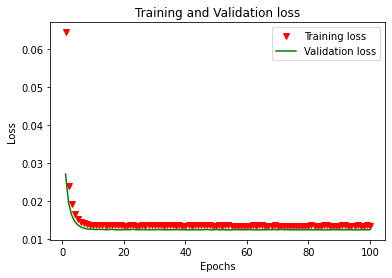

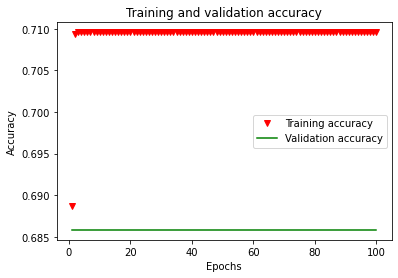

In [0]:
visualize(loss, val_loss, accuracy, val_accuracy)

**Conclusion**

**Again uisng C3D feature alone yields poor result**



**Checking model accuracy using only captions**

**Importing ground truth file from Dev-Set**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Ground-truth/')

In [0]:
fp = pd.read_csv('ground-truth.csv')

In [0]:
fp.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [0]:
fp = fp.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

**imputting ".webm" from videos**

In [0]:
fp['video'] = fp['video'].apply(lambda x : x.split('.')[0])

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Importing caption**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Captions')

In [0]:
captions_features = pd.read_csv('dev-set_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

**Removing ".txt" from video**

In [0]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [0]:
captions_features.head()

,video,Captions
0,video3,blonde-woman-is-massaged-tilt-down
1,video4,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,khr-gangsters
3,video8,medical-helicopter-hovers-at-airport
4,video10,couple-relaxing-on-picnic-crane-shot


**Combining ground truth and caption file**

In [0]:
for line in fp:
    fp['Captions'] = captions_features['Captions']

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,video3,0.924,0.846,blonde-woman-is-massaged-tilt-down
1,video4,0.923,0.667,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,0.863,0.700,khr-gangsters
3,video8,0.922,0.818,medical-helicopter-hovers-at-airport
4,video10,0.950,0.900,couple-relaxing-on-picnic-crane-shot


**Cleaning text data**

In [0]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Cleaning involves**

**Removing the special charecters,Stopwords and converting the reamining words into lowercase and creating bag of words of the remaining.**





In [0]:
corpus = []
for i in range(0, 6000):
    caption = re.sub('[^a-zA-Z]', ' ', fp['Captions'][i])
    caption = caption.lower()
    caption = caption.split()
    caption = [word for word in caption if not word in set(stopwords.words('english'))]
    caption = ' '.join(caption)
    corpus.append(caption)

**Calculating TfIdf value of each word present in bag of words**

**A) Using TfidfVectorizer**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()

**Designing Model**

**Code for Calculating Spearmann's Correlation Coefficient**

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Placing data into X and Y variables**

In [0]:
X = tf.fit_transform(corpus).toarray()
Y = fp.iloc[:, 1:3].values

**Splitting dataset into training and test set**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

**a) Implementing Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
X.shape

(6000, 5087)

In [0]:
Y_pred1 = regressor1.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.130
The Spearman's correlation coefficient is: 0.034


**b) Using KN Neighbour**

In [0]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(n_neighbors=175)

In [0]:
kn.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=175, p=2,
                    weights='uniform')

In [0]:
Y_pred1 = kn.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.351
The Spearman's correlation coefficient is: 0.158


**C) using SVR**

In [0]:
X = tf.fit_transform(corpus).toarray()
Y = fp.iloc[:, -3].values

*calculating short term score*

In [0]:
from sklearn.svm import SVR
sv = SVR()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [0]:
sv.fit(X_train,Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(X_test)
Get_score(sv_predict, Y_test)

The Spearman's correlation coefficient is: 0.392


*Calculating long term*

In [0]:
Y = fp.iloc[:,-2].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [0]:
sv.fit(X_train,Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(X_test)
Get_score(sv_predict, Y_test)

The Spearman's correlation coefficient is: 0.166


**d) Implementing Decision Tree Regression**

In [0]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
Y_pred2 = regressor2.predict(X_test)
Get_score(Y_pred2, Y_test)

The Spearman's correlation coefficient is: 0.242
The Spearman's correlation coefficient is: 0.060


**e) Implementing RandomForest Regression**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.383
The Spearman's correlation coefficient is: 0.122


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.371
The Spearman's correlation coefficient is: 0.133


**Conclusion**

**TF_IDF yields poor result when used alone.**



**Implementing count of words present in bag**

**B) Implementing CountVectorizer**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

**Splitting data Between X and Y variables**

In [0]:
X = cv.fit_transform(corpus).toarray()
Y = fp.iloc[:, 1:3].values

**Splitting dataset into Training and Test**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

**a) Using Linear Regression Model**

In [0]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
X.shape

(6000, 5087)

In [0]:
Y_pred1 = regressor1.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.127
The Spearman's correlation coefficient is: 0.058


**b) Using Decision Tree Regression Model**

In [0]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
Y_pred2 = regressor2.predict(X_test)
Get_score(Y_pred2, Y_test)

The Spearman's correlation coefficient is: 0.245
The Spearman's correlation coefficient is: 0.068


**c) Using Random Forest Regression Model**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.348
The Spearman's correlation coefficient is: 0.134


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.337
The Spearman's correlation coefficient is: 0.138


**Conclusion**

**TF_IDF performed well with Random Forest Regression when used as ensemble,where n_estimator =100.**

**A) Using weighted scores for words**

Rohit Gupta research paper on video memorability prediction suggest that certian words carry extra weight then other words. My work has just tried to improve the result using just a fration of this paper.

Importing the Ground truth Dataset

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Ground-truth')

In [0]:
fp = pd.read_csv('ground-truth.csv')

In [0]:
fp.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


**Removing annotations column**

In [0]:
fp = fp.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [0]:
fp['video'] = fp['video'].apply(lambda x : x.split('.')[0])

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Importing caption file**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Captions')

In [0]:
captions_features = pd.read_csv('dev-set_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

In [0]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [0]:
captions_features.head()

,video,Captions
0,video3,blonde-woman-is-massaged-tilt-down
1,video4,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,khr-gangsters
3,video8,medical-helicopter-hovers-at-airport
4,video10,couple-relaxing-on-picnic-crane-shot


**Combining ground truth file and captions file**

In [0]:
for line in fp:
    fp['Captions'] = captions_features['Captions']

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,video3,0.924,0.846,blonde-woman-is-massaged-tilt-down
1,video4,0.923,0.667,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,0.863,0.700,khr-gangsters
3,video8,0.922,0.818,medical-helicopter-hovers-at-airport
4,video10,0.950,0.900,couple-relaxing-on-picnic-crane-shot


Rohit Gupta research paper on video memorability prediction suggest that certian words carry extra weight then other words. My work has just tried to improve the result using just a fration of this paper.

In [0]:
weights_to_certain_words = {'women':16,'woman':16,'eating':15,'putting':14,'lying':13,'girl':12,'selfie':11,'relaxing':10,'jellyfish':9,'cat':8,'super':7,'slow':6,'super':5,'american':4,'potrait':3,'pregnant':2,'couple':1}

**Filtering text data**

In [0]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Cleaning involves:**


**Adding weight to certain words, if they are present in bag of words.**

In [0]:
corpus = []
weights = []
for i in range(0, 6000):
    local_weight = 0
    caption = re.sub('[^a-zA-Z]', ' ', fp['Captions'][i])
    caption = caption.lower()
    caption = caption.split()
    caption = [word for word in caption if not word in set(stopwords.words('english'))]
    for word in caption:
        if(word in set(weights_to_certain_words.keys())):
                local_weight = local_weight + weights_to_certain_words[word]
    weights.append(local_weight)
    caption = ' '.join(caption)
    corpus.append(caption)

In [0]:
weights_df = pd.DataFrame(np.array(weights).reshape(6000,1))

**Since TfIdf Vectorizer outperformed Count Vectorizer, using TfIdf Vectorizer for further evaluations.**

**Using TfIdf value of each word occurance amongst the bag of words.**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()

In [0]:
captions_array = tf.fit_transform(corpus).toarray()

In [0]:
merged_array = np.concatenate((captions_array, weights_df), axis=1)

**Designing Model**

**Code for Calculating Spearmann's Correlation Coefficient**

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Splitting data between X and Y variables**

In [0]:
X = merged_array
Y = fp.iloc[:, 1:3].values

**Splitting dataset into train and test set**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

**a) Implementing Linear Regression Model**

In [0]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Y_pred1 = regressor1.predict(X_test)
Get_score(Y_pred1, Y_test)

The Spearman's correlation coefficient is: 0.125
The Spearman's correlation coefficient is: 0.127


**b) using SVR**

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,video3,0.924,0.846,blonde-woman-is-massaged-tilt-down
1,video4,0.923,0.667,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,0.863,0.700,khr-gangsters
3,video8,0.922,0.818,medical-helicopter-hovers-at-airport
4,video10,0.950,0.900,couple-relaxing-on-picnic-crane-shot


*calulcating short-term score*

In [0]:
X = merged_array
Y = fp.iloc[:, -3].values

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [0]:
from sklearn.svm import SVR
sv = SVR()

In [0]:
sv.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(x_test)
Get_score(sv_predict, y_test)

The Spearman's correlation coefficient is: 0.419


*calculating long-term score*

In [0]:
Y = fp.iloc[:,-2].values

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [0]:
from sklearn.svm import SVR
sv = SVR()

In [0]:
sv.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(x_test)
Get_score(sv_predict, y_test)

The Spearman's correlation coefficient is: 0.160


**C) Implementing Decision Tree Model**

In [0]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_train, Y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
Y_pred2 = regressor2.predict(X_test)
Get_score(Y_pred2, Y_test)

The Spearman's correlation coefficient is: 0.287
The Spearman's correlation coefficient is: 0.142


**d) Implementing Random Forest Regression Model**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.445
The Spearman's correlation coefficient is: 0.200


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.447
The Spearman's correlation coefficient is: 0.203


In [0]:
n_col = X_train.shape[1]

In [0]:
cap_model_nn = baseline_model(n_col)
history = cap_model_nn.fit(X_train,Y_train, epochs=100, verbose=0, validation_data=(X_test,Y_test))

In [0]:
def baseline_model(n_col):
    '''
    Creating a sequential model for neural network
    '''
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(n_col,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal'))
    model.add(layers.Dense(2, activation='sigmoid')) 
    model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy']) 
 
    return model

In [0]:
def visualize(loss, val_loss, accuracy, val_accuracy):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'rv',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, accuracy, 'rv', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
cap_predictions_nn = cap_model_nn.predict(X_test)
Get_score(cap_predictions_nn, Y_test)

The Spearman's correlation coefficient is: 0.404
The Spearman's correlation coefficient is: 0.243


In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

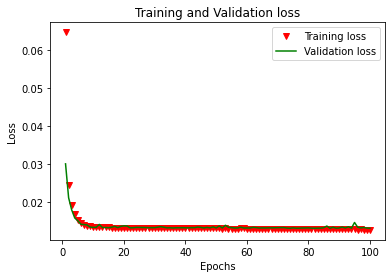

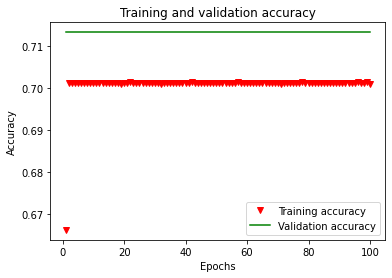

In [0]:
visualize(loss, val_loss, accuracy, val_accuracy)

**Conclusion**

**When extra weight are add on to some caption it outperformed every other model and give the best possible result. A spearman correlation of 0.447**



**Using C3D+Caption**

**Importing Ground truth Dataset**

In [0]:
os.chdir(r'/gdrive/My Drive/CA684_Assignment/Dev-set/Ground-truth')

In [0]:
fp = pd.read_csv('ground-truth.csv')

**Removing annotation column**

In [0]:
fp = fp.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

**Removing .txt from videos name to matach it with C3D features.**

In [0]:
fp['video'] = fp['video'].apply(lambda x : x.split('.')[0])

In [0]:
fp.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Importing caption file from Dev_test**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/Captions')

In [0]:
captions_features = pd.read_csv('dev-set_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

**Removing .txt from video name**

In [0]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [0]:
captions_features.head()

,video,Captions
0,video3,blonde-woman-is-massaged-tilt-down
1,video4,roulette-table-spinning-with-ball-in-closeup-shot
2,video6,khr-gangsters
3,video8,medical-helicopter-hovers-at-airport
4,video10,couple-relaxing-on-picnic-crane-shot


**Cleaning text data**

In [0]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
corpus = []
for i in range(0, 6000):
    caption = re.sub('[^a-zA-Z]', ' ', captions_features['Captions'][i])
    caption = caption.lower()
    caption = caption.split()
    caption = [word for word in caption if not word in set(stopwords.words('english'))]
    caption = ' '.join(caption)
    corpus.append(caption)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()

In [0]:
captions_array = tf.fit_transform(corpus).toarray()

**Importing C3D file**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Dev-set/C3D')

In [0]:
C3D_feature = []
video_name = []
for py in glob.glob('*.txt'):
    channel_values = open(py).read().split(" ")
    channel_values = np.array(channel_values)
    fp = []
    for i in range(len(channel_values)):
        fp.append(channel_values[i])
    C3D_feature.append(fp)
    py1 = py.split('.')
    video_name.append(py1[0])

**Converting feature into dataframe**

In [0]:
C3D_features = pd.DataFrame(C3D_feature)
C3D_features['video'] = video_name

In [0]:
C3D_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,video
0,0.01085767,0.01038633,0.00000000,0.00000000,0.00000000,0.00000000,0.00000027,0.00000000,0.00000001,0.00000034,0.00000008,0.00000001,0.00000376,0.00010543,0.00000000,0.00000004,0.00000001,0.00000000,0.00000000,0.00013318,0.00000000,0.00000000,0.00000000,0.00000000,0.00000076,0.00000000,0.00000098,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000006,0.00002108,0.00000005,0.00000000,0.00000001,0.00000003,0.00000002,0.00000000,...,0.00001565,0.00129776,0.00003158,0.00000104,0.00000000,0.00000000,0.00000001,0.00000025,0.00000000,0.00000000,0.00000005,0.00000000,0.00000001,0.00000001,0.00000042,0.00000000,0.00000003,0.00000002,0.00000000,0.00000000,0.00000000,0.00000006,0.00000000,0.00000000,0.00000009,0.00000000,0.00000000,0.00000011,0.00000014,0.00000000,0.00000000,0.00000017,0.00000000,0.00000000,0.00000001,0.00000130,0.00000260,0.00000008,,video6632
1,0.00019951,0.00006494,0.99380690,0.00000020,0.00000047,0.00007339,0.00000370,0.00033711,0.00000671,0.00000229,0.00000638,0.00000734,0.00001901,0.00000708,0.00000324,0.00000381,0.00001411,0.00000104,0.00000271,0.00000023,0.00000019,0.00293762,0.00000052,0.00000092,0.00001136,0.00001055,0.00033104,0.00000092,0.00002189,0.00000008,0.00002769,0.00001254,0.00005778,0.00003655,0.00001683,0.00000686,0.00000399,0.00000803,0.00000145,0.00000038,...,0.00001333,0.00007721,0.00004986,0.00013829,0.00001209,0.00000719,0.00000041,0.00000544,0.00000034,0.00000687,0.00008399,0.00000407,0.00000397,0.00000059,0.00012853,0.00000088,0.00002228,0.00001105,0.00000267,0.00001488,0.00001361,0.00000409,0.00000332,0.00000460,0.00000492,0.00000529,0.00000064,0.00002372,0.00000661,0.00001024,0.00000203,0.00000580,0.00000149,0.00000149,0.00001170,0.00000015,0.00000083,0.00010600,,video6634
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000775,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.99998510,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000712,,video6633
3,0.00595937,0.00476483,0.00375688,0.00057871,0.00007344,0.00012882,0.00046653,0.01026567,0.00030281,0.00021965,0.00025218,0.00296373,0.00003215,0.00059248,0.00003260,0.00146643,0.00024307,0.00018084,0.00401918,0.00239096,0.00012069,0.00848849,0.00052162,0.00041646,0.01643420,0.04968638,0.00147055,0.00005432,0.00105523,0.00544277,0.00017277,0.02468789,0.00096407,0.00088023,0.01140529,0.00452216,0.00085945,0.00065730,0.00069424,0.00182311,...,0.01410887,0.00047150,0.00246050,0.00404576,0.00090518,0.00099672,0.00251466,0.00158744,0.00112503,0.00100841,0.02133877,0.00064747,0.00137301,0.00009568,0.05635083,0.00001628,0.00537991,0.00602002,0.04649908,0.02394238,0.02065825,0.00334952,0.00263711,0.00009376,0.01170705,0.00022909,0.00978921,0.00276439,0.00805235,0.00399155,0.00413661,0.03670390,0.00076651,0.00036921,0.01251980,0.00008422,0.01159825,0.00115504,,video6645
4,0.00578192,0.00030562,0.00401076,0.00001007,0.00001034,0.00000174,0.00000316,0.00000332,0.00001984,0.00000575,0.00006642,0.00000669,0.00030087,0.00479859,0.00000028,0.00001669,0.00000267,0.00000106,0.00001062,0.00006526,0.00000031,0.00003590,0.00000140,0.000

In [0]:
C3D_features.drop(labels=101,axis=1,inplace=True)

**Merging C3D features and ground truth together**

In [0]:
pdf = pd.merge(fp, C3D_features , on='video')

In [0]:
pdf.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3,0.924,0.846,0.02024942,0.00157780,0.00082625,0.00094509,0.00006279,0.00000349,0.00116182,0.00009742,0.00002179,0.00001033,0.00033725,0.00063631,0.00011117,0.00100782,0.00000361,0.00063123,0.00003905,0.00004098,0.00009125,0.00030321,0.00001541,0.00003197,0.00005221,0.00006155,0.01746459,0.00066581,0.00006527,0.00005445,0.00027318,0.00138588,0.00000333,0.00135579,0.00051650,0.00242612,0.00271914,0.00000277,0.00155708,...,0.09664717,0.00445773,0.01184005,0.00028666,0.00219519,0.00279224,0.00001774,0.00336507,0.00006105,0.00057339,0.00027257,0.00003430,0.00673736,0.00002083,0.00009779,0.00002502,0.00576786,0.00000299,0.00008473,0.00060710,0.00046061,0.00118864,0.00027025,0.00012745,0.00010562,0.00015450,0.00056664,0.00001960,0.00089388,0.00107945,0.00104165,0.00016135,0.00025716,0.04661711,0.00015613,0.00000604,0.00053682,0.00033907,0.00843683,0.00047004
1,video4,0.923,0.667,0.00011800,0.00089075,0.00018769,0.00004543,0.00006330,0.00000162,0.00064061,0.00001127,0.00001727,0.00001396,0.00033635,0.00408054,0.00000059,0.00041122,0.00000257,0.00024295,0.00000066,0.00000193,0.00053526,0.00027848,0.00004804,0.00115288,0.00002792,0.00004034,0.02227584,0.00452932,0.00001997,0.00002861,0.00004501,0.06043553,0.00003903,0.02720771,0.00007363,0.00002719,0.00062251,0.00026096,0.00018345,...,0.00037183,0.00015437,0.00014788,0.00008598,0.00026692,0.00001412,0.00142971,0.00441655,0.00006437,0.00010511,0.00312861,0.00005459,0.00006118,0.00002513,0.00428276,0.00001032,0.00006230,0.00002903,0.00037445,0.00013927,0.74170244,0.00717841,0.00034567,0.00010432,0.00018070,0.00005201,0.00483861,0.00007809,0.04232508,0.00062290,0.00058212,0.00039252,0.00086398,0.00094723,0.00013558,0.00000668,0.00036014,0.00015891,0.00102521,0.00002046
2,video6,0.863,0.700,0.01176522,0.00074577,0.00078353,0.00001328,0.00000681,0.00002833,0.00004069,0.00001409,0.00004129,0.00008288,0.00004840,0.00007962,0.00106661,0.00095809,0.00001143,0.00007013,0.00002992,0.00003840,0.00003073,0.00000792,0.00000097,0.00290505,0.00001849,0.00001347,0.00019197,0.00004972,0.00053191,0.00002705,0.00005094,0.00001000,0.00000474,0.00002926,0.00003257,0.03260172,0.00003366,0.00000071,0.00000606,...,0.87629104,0.00550869,0.00885157,0.00039916,0.00006906,0.01316573,0.00001459,0.00004403,0.00052008,0.00004558,0.00000735,0.00002440,0.01049062,0.00047454,0.00002327,0.00000559,0.00555386,0.00000025,0.00005689,0.00032751,0.00014941,0.00184387,0.00000841,0.00010340,0.00003019,0.00000502,0.00017922,0.00000111,0.00000595,0.00021468,0.00022408,0.00000259,0.00003066,0.00253824,0.00010374,0.00000468,0.00006409,0.00538033,0.00102748,0.00138448
3,video8,0.922,0.818,0.00022343,0.00016499,0.00000735,0.00001615,0.00000534,0.00001420,0.00015360,0.00000781,0.00000355,0.00000930,0.00105671,0.00012554,0.00003404,0.00000429,0.00000556,0.00001234,0.00000194,0.00000259,0.00175854,0.00000491,0.00000833,0.00002721,0.00000032,0.00001017,0.00013732,0.00000629,0.00000512,0.00000759,0.00000840,0.00061086,0.00016640,0.58321434,0.00000435,0.00000021,0.00000157,0.00002136,0.00000267,...,0.00000935,0.00000660,0.00000466,0.00053899,0.00003492,0.00039140,0.00002065,0.00004341,0.00001017,0.00002843,0.01247148,0.00667063,0.00118678,0.00000158,0.11948825,0.00000056,0.00000396,0.00000425,0.00004049,0.00014772,0.10398888,0.05898904,0.00000222,0.00006931,0.00000361,0.00012997,0.00118247,0.00000267,0.00000616,0.00004401,0.00004565,0.00000873,0.00002278,0.00005279,0.00004790,0.00001950,0.00000141,0.00000449,0.00037993,0.00002851
4,video10,0.950,0.900,0.00009006,0.00061494,0.00343634,0.00128092,0.00355140,0.00031288,0.00004187,0.00001821,0.00015741,0.00011713,0.00025598,0.00011594,0.00032348,0.00988849,0.00000105,0.00057635,0.00003004,0.00000765,0.00202887,0

In [0]:
C3D_array = pdf.iloc[:,3:104].values

In [0]:
C3D_array.shape

(6000, 101)

**C3D features and caption merged**

In [0]:
merged_array = np.concatenate((captions_array, C3D_array), axis=1)

**Designing Model**

**Code for Calculating Spearmann's Correlation Coefficient**

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Splitting data into X and Y variables**

In [0]:
X = merged_array

In [0]:
Y = fp.iloc[:, 1:3].values

**Splitting dataset into Training and Test set**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30)

**Using Random Forest Regression Model**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100)
regressor3.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
Y_pred3 = regressor3.predict(X_test)
Get_score(Y_pred3, Y_test)

The Spearman's correlation coefficient is: 0.312
The Spearman's correlation coefficient is: 0.110


**Conclusion**

**Combination of C3D and captions yields better results than simple C3D features.** **But it doesn't perform better than captions alone or captions with weights**

**using combination of C3D + captions with weigth**

In [0]:
pdf.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3,0.924,0.846,0.02024942,0.00157780,0.00082625,0.00094509,0.00006279,0.00000349,0.00116182,0.00009742,0.00002179,0.00001033,0.00033725,0.00063631,0.00011117,0.00100782,0.00000361,0.00063123,0.00003905,0.00004098,0.00009125,0.00030321,0.00001541,0.00003197,0.00005221,0.00006155,0.01746459,0.00066581,0.00006527,0.00005445,0.00027318,0.00138588,0.00000333,0.00135579,0.00051650,0.00242612,0.00271914,0.00000277,0.00155708,...,0.09664717,0.00445773,0.01184005,0.00028666,0.00219519,0.00279224,0.00001774,0.00336507,0.00006105,0.00057339,0.00027257,0.00003430,0.00673736,0.00002083,0.00009779,0.00002502,0.00576786,0.00000299,0.00008473,0.00060710,0.00046061,0.00118864,0.00027025,0.00012745,0.00010562,0.00015450,0.00056664,0.00001960,0.00089388,0.00107945,0.00104165,0.00016135,0.00025716,0.04661711,0.00015613,0.00000604,0.00053682,0.00033907,0.00843683,0.00047004
1,video4,0.923,0.667,0.00011800,0.00089075,0.00018769,0.00004543,0.00006330,0.00000162,0.00064061,0.00001127,0.00001727,0.00001396,0.00033635,0.00408054,0.00000059,0.00041122,0.00000257,0.00024295,0.00000066,0.00000193,0.00053526,0.00027848,0.00004804,0.00115288,0.00002792,0.00004034,0.02227584,0.00452932,0.00001997,0.00002861,0.00004501,0.06043553,0.00003903,0.02720771,0.00007363,0.00002719,0.00062251,0.00026096,0.00018345,...,0.00037183,0.00015437,0.00014788,0.00008598,0.00026692,0.00001412,0.00142971,0.00441655,0.00006437,0.00010511,0.00312861,0.00005459,0.00006118,0.00002513,0.00428276,0.00001032,0.00006230,0.00002903,0.00037445,0.00013927,0.74170244,0.00717841,0.00034567,0.00010432,0.00018070,0.00005201,0.00483861,0.00007809,0.04232508,0.00062290,0.00058212,0.00039252,0.00086398,0.00094723,0.00013558,0.00000668,0.00036014,0.00015891,0.00102521,0.00002046
2,video6,0.863,0.700,0.01176522,0.00074577,0.00078353,0.00001328,0.00000681,0.00002833,0.00004069,0.00001409,0.00004129,0.00008288,0.00004840,0.00007962,0.00106661,0.00095809,0.00001143,0.00007013,0.00002992,0.00003840,0.00003073,0.00000792,0.00000097,0.00290505,0.00001849,0.00001347,0.00019197,0.00004972,0.00053191,0.00002705,0.00005094,0.00001000,0.00000474,0.00002926,0.00003257,0.03260172,0.00003366,0.00000071,0.00000606,...,0.87629104,0.00550869,0.00885157,0.00039916,0.00006906,0.01316573,0.00001459,0.00004403,0.00052008,0.00004558,0.00000735,0.00002440,0.01049062,0.00047454,0.00002327,0.00000559,0.00555386,0.00000025,0.00005689,0.00032751,0.00014941,0.00184387,0.00000841,0.00010340,0.00003019,0.00000502,0.00017922,0.00000111,0.00000595,0.00021468,0.00022408,0.00000259,0.00003066,0.00253824,0.00010374,0.00000468,0.00006409,0.00538033,0.00102748,0.00138448
3,video8,0.922,0.818,0.00022343,0.00016499,0.00000735,0.00001615,0.00000534,0.00001420,0.00015360,0.00000781,0.00000355,0.00000930,0.00105671,0.00012554,0.00003404,0.00000429,0.00000556,0.00001234,0.00000194,0.00000259,0.00175854,0.00000491,0.00000833,0.00002721,0.00000032,0.00001017,0.00013732,0.00000629,0.00000512,0.00000759,0.00000840,0.00061086,0.00016640,0.58321434,0.00000435,0.00000021,0.00000157,0.00002136,0.00000267,...,0.00000935,0.00000660,0.00000466,0.00053899,0.00003492,0.00039140,0.00002065,0.00004341,0.00001017,0.00002843,0.01247148,0.00667063,0.00118678,0.00000158,0.11948825,0.00000056,0.00000396,0.00000425,0.00004049,0.00014772,0.10398888,0.05898904,0.00000222,0.00006931,0.00000361,0.00012997,0.00118247,0.00000267,0.00000616,0.00004401,0.00004565,0.00000873,0.00002278,0.00005279,0.00004790,0.00001950,0.00000141,0.00000449,0.00037993,0.00002851
4,video10,0.950,0.900,0.00009006,0.00061494,0.00343634,0.00128092,0.00355140,0.00031288,0.00004187,0.00001821,0.00015741,0.00011713,0.00025598,0.00011594,0.00032348,0.00988849,0.00000105,0.00057635,0.00003004,0.00000765,0.00202887,0

In [0]:
C3D_array = pdf.iloc[:,3:104].values

*Merging caption with weigths with C3D*

In [0]:
merged_array

array([[ 0.,  0.,  0., ...,  0.,  0., 16.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 16.],
       [ 0.,  0.,  0., ...,  0.,  0., 16.]])

In [0]:
merged = np.concatenate((merged_array, C3D_array), axis=1)

In [0]:
x = merged

In [0]:
y = pdf['short-term_memorability']

*Code for Calculating Spearmann's Correlation Coefficient*

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

**a) uisng SVR**

In [0]:
from sklearn.svm import SVR
sv = SVR()

*Calculating short-term score*

In [0]:
sv.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(x_test)
Get_score(sv_predict, y_test)

The Spearman's correlation coefficient is: 0.382


*Calculating long-term score*

In [0]:
y = pdf['long-term_memorability']

In [0]:
sv.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
sv_predict = sv.predict(x_test)
Get_score(sv_predict, y_test)

The Spearman's correlation coefficient is: 0.205


**b) using KNN Regressor**

*Calculating short-term*

In [0]:
y = pdf['short-term_memorability']

In [0]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(n_neighbors=175)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [0]:
kn.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=175, p=2,
                    weights='uniform')

In [0]:
kn_predict = kn.predict(x_test)
Get_score(kn_predict, y_test)

The Spearman's correlation coefficient is: 0.327


*Calculating Long-term*

In [0]:
y = pdf['long-term_memorability']

In [0]:
kn.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=175, p=2,
                    weights='uniform')

In [0]:
kn_predict = kn.predict(x_test)
Get_score(kn_predict, y_test)

The Spearman's correlation coefficient is: 0.167


**c) using ensembler random forest**

*calculating short -term score*

In [0]:
y = pdf['short-term_memorability']

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFF = RandomForestRegressor(n_estimators=100)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [0]:
RFF.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
RFF_predict = RFF.predict(x_test)
Get_score(RFF_predict, y_test)

The Spearman's correlation coefficient is: 0.370


*calculating long-term score*

In [0]:
y = pdf['long-term_memorability']

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFF = RandomForestRegressor(n_estimators=100)
RFF.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
RFF_predict = RFF.predict(x_test)
Get_score(RFF_predict, y_test)

The Spearman's correlation coefficient is: 0.181


**conclusion**

**using best feature of videos(C3D) and best feature from semantic(caption+weight). The result didn't improve much. Although this new feature performed better than all other except Caption with weight. But didn't outperformed it.**

**Final Submission**

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Test-set/Ground-truth_test')

In [0]:
fp = pd.read_csv('ground_truth_template.csv')

In [180]:
fp.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [0]:
fp = fp.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [0]:
os.chdir('/gdrive/My Drive/CA684_Assignment/Test-set/Captions_test')

In [0]:
captions_features = pd.read_csv('test-set-1_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))

In [0]:
captions_features['video'] = captions_features['video'].apply(lambda x : x.split('.')[0])

In [186]:
captions_features.head()

,video,Captions
0,video7494,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496,close-up-of-african-american-doctors-hands-usi...
3,video7497,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498,slow-motion-of-photographer-in-national-park


In [0]:
for line in fp:
    fp['Captions'] = captions_features['Captions']

In [188]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,7494,NaN,NaN,green-jeep-struggling-to-drive-over-huge-rocks
1,7495,NaN,NaN,hiking-woman-tourist-is-walking-forward-in-mou...
2,7496,NaN,NaN,close-up-of-african-american-doctors-hands-usi...
3,7497,NaN,NaN,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,7498,NaN,NaN,slow-motion-of-photographer-in-national-park


In [0]:
weights_to_certain_words = {'women':16,'woman':16,'eating':15,'putting':14,'lying':13,'girl':12,'selfie':11,'relaxing':10,'jellyfish':9,'cat':8,'super':7,'slow':6,'super':5,'american':4,'potrait':3,'pregnant':2,'couple':1}

In [164]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
corpus = []
weights = []
for i in range(0, 2000):
    local_weight = 0
    caption = re.sub('[^a-zA-Z]', ' ', fp['Captions'][i])
    caption = caption.lower()
    caption = caption.split()
    caption = [word for word in caption if not word in set(stopwords.words('english'))]
    for word in caption:
        if(word in set(weights_to_certain_words.keys())):
                local_weight = local_weight + weights_to_certain_words[word]
    weights.append(local_weight)
    caption = ' '.join(caption)
    corpus.append(caption)

In [0]:
weights_df = pd.DataFrame(np.array(weights).reshape(2000,1))

In [0]:
captions_array = tf.transform(corpus).toarray()

In [193]:
captions_array.shape

(2000, 5087)

In [0]:
merged_array = np.concatenate((captions_array, weights_df), axis=1)

In [0]:
X = merged_array

In [0]:
Out_Y_pred3 = regressor3.predict(X)

In [147]:
Out_Y_pred3

array([[0.83425942, 0.77101   ],
       [0.762974  , 0.7666485 ],
       [0.9129175 , 0.84041833],
       ...,
       [0.901956  , 0.7434655 ],
       [0.88882722, 0.83302333],
       [0.92026933, 0.82776133]])

In [0]:
Final_Submission = pd.DataFrame(Out_Y_pred3)

**Neural Network**

In [0]:
n_col = X_train.shape[1]

In [0]:
out_cap_predictions_nn = cap_model_nn.predict(X)

In [197]:
out_cap_predictions_nn

array([[0.84131557, 0.75396746],
       [0.91951567, 0.8657706 ],
       [0.8839268 , 0.81334066],
       ...,
       [0.8613671 , 0.78055316],
       [0.8679813 , 0.7929594 ],
       [0.9271276 , 0.8761292 ]], dtype=float32)

In [0]:
Final_Submission1 = pd.DataFrame(out_cap_predictions_nn)

In [0]:
Final_Submission.rename(columns={0:'short-term_memorability',1:'long-term_memorability'},inplace=True)

In [0]:
Final_Submission1.rename(columns={0:'short-term_memorability',1:'long-term_memorability'},inplace=True)

In [203]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,7494,NaN,NaN,green-jeep-struggling-to-drive-over-huge-rocks
1,7495,NaN,NaN,hiking-woman-tourist-is-walking-forward-in-mou...
2,7496,NaN,NaN,close-up-of-african-american-doctors-hands-usi...
3,7497,NaN,NaN,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,7498,NaN,NaN,slow-motion-of-photographer-in-national-park


In [0]:
fp['short-term_memorability']=Final_Submission['short-term_memorability']

In [0]:
fp['long-term_memorability']=Final_Submission1['long-term_memorability']

In [207]:
fp.head()

,video,short-term_memorability,long-term_memorability,Captions
0,7494,0.834259,0.753967,green-jeep-struggling-to-drive-over-huge-rocks
1,7495,0.762974,0.865771,hiking-woman-tourist-is-walking-forward-in-mou...
2,7496,0.912917,0.813341,close-up-of-african-american-doctors-hands-usi...
3,7497,0.877720,0.790644,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,7498,0.834463,0.765882,slow-motion-of-photographer-in-national-park


In [208]:
fp.tail()

,video,short-term_memorability,long-term_memorability,Captions
1995,10004,0.899309,0.787285,astronaut-in-outer-space-against-the-backdrop-...
1996,10005,0.908722,0.872317,young-women-lying-on-sunbed-and-applying-sun-c...
1997,10006,0.901956,0.780553,doctor-talking-to-patient-using-a-tablet-to-ex...
1998,10007,0.888827,0.792959,businessman-sitting-on-the-beach-on-inflatable...
1999,10008,0.920269,0.876129,woman-eating-ice-cream-and-sitting-in-the-stre...


In [0]:
os.chdir('/gdrive/My Drive')

In [0]:
fp.to_csv('Predicted_Score.csv')